# Multiclass Peak Detection in fDOM

This file combines all of the fDOM detection scripts into a singular classifier, that detects all peak types. On top of this, it also leverages the augmented data created previously.

## Structure

The core structure of the project is to have all individual classifiers running, and then when one detects a peak, it alerts the overall classifier "manager", which then takes note of the peak that a classifier has detected as an anomaly peak.


In [1]:
# Imports
import scipy.io as sio
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sn
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    classification_report,
)
import pandas as pd
import numpy as np
import datetime
import sys
import copy
import matplotlib.pyplot as plt

sys.path.insert(1, "../")
import Tools.data_processing as dp
import Tools.data_movement as dm
from get_cands import get_all_cands_fDOM, get_all_truths_fDOM

# import classifiers
from fdom_classifiers.fDOM_PLP import fDOM_PLP_Classifier
from fdom_classifiers.fDOM_FPT import fDOM_FPT_Classifier
from fdom_classifiers.fDOM_FSK import fDOM_FSK_Classifier
from fdom_classifiers.fDOM_PP import fDOM_PP_Classifier
from fdom_classifiers.fDOM_SKP import fDOM_SKP_Classifier


In [2]:
# TODO: REMOVE THIS WHEN FINISHED MODIFYING
%load_ext autoreload
%autoreload 2

## Training parameters and helper functions


In [3]:
ITERATIONS = 7000
NUM_SPLITS = 5
AUGMENT_DATA_BEGIN_TIMESTAMP = 2459096.9583333335
USE_AUGMENTED_DATA = True

# for confusion matrix
DATA_LABELS = ["PLP", "FPT", "FSK", "SKP", "PP", "NAP"]

# Useful functions
def get_prediction(plp_pred, skp_pred=None, pp_pred=None, fsk_pred=None, fpt_pred=None):
    """
    take the top level prediction based on peak precendence
    """
    if plp_pred == "PLP":
        return plp_pred

    elif pp_pred == "PP":
        return pp_pred

    elif skp_pred == "SKP":
        return skp_pred

    elif fsk_pred == "FSK":
        return fsk_pred
        
    elif fpt_pred == "FPT":
        return fpt_pred

    else:
        return "NAP"

In [4]:
# Filenames
fdom_raw_data = "../Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
stage_raw_data = "../Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
turb_raw_data = "../Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"

fdom_labeled = "../Data/labeled_data/ground_truths/fDOM/fDOM_all_julian_0k-300k.csv"

fdom_raw_augmented = "../Data/augmented_data/fdom/unlabeled/unlabeled_fdom.csv"
fdom_labeled_augmented = "../Data/augmented_data/fdom/labeled/labeled_fdom_peaks.csv"

turb_augmented_raw_data = "../Data/augmented_data/fdom/unlabeled/unlabeled_turb.csv"

stage_augmented_data_fn = "../Data/augmented_data/fdom/unlabeled/unlabeled_stage.csv"

In [5]:
# Load Data
fDOM_data = dm.read_in_preprocessed_timeseries(fdom_raw_data)
stage_data = dm.read_in_preprocessed_timeseries(stage_raw_data)
turb_data = dm.read_in_preprocessed_timeseries(turb_raw_data)
stage_data = dp.align_stage_to_fDOM(fDOM_data, stage_data)

augmented_fdom_data = np.array(dm.read_in_timeseries(fdom_raw_augmented, True))
augmented_turb_data = np.array(dm.read_in_timeseries(turb_augmented_raw_data, True))
augmented_stage_data = np.array(dm.read_in_timeseries(stage_augmented_data_fn, True))


## Get Candidates and truths

In [6]:
# get candidates from raw data
cands = get_all_cands_fDOM(
    fdom_raw_data,
    fdom_labeled,
)

# get truths from raw data
truths = get_all_truths_fDOM(fdom_labeled)

print(truths.shape)

# assert they are the same size
assert truths.shape == cands.shape


/Users/claykaufmann/Projects/srrw-anomaly-detection/Multiclass_Detection/../Tools/get_candidates.py:221: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(
/Users/claykaufmann/Projects/srrw-anomaly-detection/Multiclass_Detection/../Tools/get_candidates.py:335: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(


(1636, 4)


### Augmented Data
Make sure that `USE_AUGMENTED_DATA` == `True`, for this data to take effect

In [7]:
if USE_AUGMENTED_DATA:
    # get candidates from augmented data
    cands_augmented = get_all_cands_fDOM(
        fdom_raw_augmented,
        fdom_labeled_augmented,
        True,
    )

    truths_augmented = get_all_truths_fDOM(fdom_labeled_augmented, True)

    # align the missing augmented data (FPT, NFPT, FSK, NFSK, some others)
    truths_augmented = truths_augmented[
        truths_augmented["idx_of_peak"].isin(cands_augmented["idx_of_peak"])
    ]

    assert truths_augmented.shape == cands_augmented.shape

    print(f"Total number of augmented candidates: {cands.shape[0]}")

    # concatenate two candidates and truths into single list
    cands = pd.concat([cands, cands_augmented])
    truths = pd.concat([truths, truths_augmented])

    # concat augmented raw data to normal raw data, for classifier preprocessing
    turb_data_total = np.concatenate((turb_data, augmented_turb_data))
    fdom_total = np.concatenate((fDOM_data, augmented_fdom_data))
    stage_total = np.concatenate((stage_data, augmented_stage_data))

# if we aren't using augmented data, make sure classifiers have correct data being passed into them for preprocessing
else:
    turb_data_total = turb_data
    fdom_total = fDOM_data
    stage_total = stage_data


(676, 4)
(676, 4)


In [9]:
# Convert cands and truths into lists
cands = cands.values.tolist()

truths = truths.values.tolist()

print(str(len(cands)) + " candidates in provided data.")

2312 candidates in provided data.


## Create Classifiers


In [10]:
plp_classifer = fDOM_PLP_Classifier(
    fDOM_data,
    turb_data_total,
    fdom_raw_data,
    fdom_labeled,
    fdom_raw_augmented,
    fdom_labeled_augmented
)


/Users/claykaufmann/Projects/srrw-anomaly-detection/Multiclass_Detection/../Tools/get_candidates.py:221: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(
/Users/claykaufmann/Projects/srrw-anomaly-detection/Multiclass_Detection/../Tools/get_candidates.py:335: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(


In [11]:
skp_classifier = fDOM_SKP_Classifier(
    fdom_total,
    fdom_raw_data,
    fdom_labeled,
    fdom_raw_augmented,
    fdom_labeled_augmented
)

/Users/claykaufmann/Projects/srrw-anomaly-detection/Multiclass_Detection/../Tools/get_candidates.py:221: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(
/Users/claykaufmann/Projects/srrw-anomaly-detection/Multiclass_Detection/../Tools/get_candidates.py:335: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(
/Users/claykaufmann/Projects/srrw-anomaly-detection/Multiclass_Detection/fdom_classifiers/fDOM_SKP.py:257: PeakPropertyWarning: some peaks have a prominence of 0
  downward_peaks, _ = find_peaks(


In [12]:
pp_classifier = fDOM_PP_Classifier(
    fdom_total,
    stage_total, # CHANGED TO BE ENTURE STAGE, this could help
    AUGMENT_DATA_BEGIN_TIMESTAMP
)

In [13]:
# fpt_classifier = fDOM_FPT_Classifier()

In [14]:
# fsK_classifier = fDOM_FSK_Classifier()

## Training Loop

In [15]:
accumulated_test_metrics = {}

accumulated_test_results = {}

accumulated_best_params = {}

accumulated_cfmxs = {}

best_params = {}

# split data
train_test_split_indices = TimeSeriesSplit(NUM_SPLITS).split(cands)

overall_start = datetime.datetime.now()

split = 1
divide_by_zero_errs = 0

for train_val_indices, test_indices in train_test_split_indices:
    X_train, y_train = [cands[i] for i in train_val_indices], [
        truths[i] for i in train_val_indices
    ]

    X_test, y_test = [cands[i] for i in test_indices], [truths[i] for i in test_indices]

    max_fold_metric = 0
    max_result = None

    print("\nSplit: ", split)

    split_start = datetime.datetime.now()

    # TODO: check on these two lines, unsure what they really do
    num_pos_test = len(list(filter(lambda x: x[2] != "NAP", y_test)))
    num_pos_train = len(list(filter(lambda x: x[2] != "NAP", y_train)))

    print(f"Num Pos in Test: {num_pos_test}")
    print(f"Num Pos in Train: {num_pos_train}")

    if num_pos_test >= 1 and num_pos_train >= 1:

        # main training loop
        for iteration in range(ITERATIONS):
            # start the iteration for each classifier (resets predictions, generates params)
            plp_classifer.start_iteration()
            skp_classifier.start_iteration()
            pp_classifier.start_iteration()

            # reset results
            train_preds = []

            # iterate over list of peaks
            for i, peak in enumerate(X_train):
                plp_result = plp_classifer.classify_sample(i, peak)
                skp_result = skp_classifier.classify_sample(i, peak)
                pp_result = pp_classifier.classify_sample(i, peak)

                # append to results data structure, the index of peak, and all of the results
                pred = get_prediction(plp_result, skp_result, pp_result)
                train_preds.append([peak[0], pred])

            # print out info for user
            if iteration and iteration % int(ITERATIONS / 10) == 0:
                print(" {}/{} ".format(iteration, ITERATIONS), end="")

            # test predictions
            # FIXME: the balanced acc is extremely low for some reason
            bal_acc = balanced_accuracy_score(
                [row[2] for row in y_train],
                [row[1] for row in train_preds],
            )

            acc = accuracy_score(
                [row[2] for row in y_train],
                [row[1] for row in train_preds],
            )

            # check acc
            if bal_acc > max_fold_metric:
                max_fold_metric = acc
                max_result = copy.deepcopy(train_preds)

                # save params of classifiers
                plp_classifer.got_best_result()
                skp_classifier.got_best_result()
                pp_classifier.got_best_results()

                # save the best params
                best_params["PLP"] = plp_classifer.best_params
                best_params["SKP"] = skp_classifier.best_params
                best_params["PP"] = pp_classifier.best_params


            # call end of iteration, as we are at the end of an iteration
            # allows individual classifiers to calc results
            plp_classifer.end_of_iteration(y_train)
            skp_classifier.end_of_iteration(y_train)
            pp_classifier.end_of_iteration(y_train)

        # perform peak testing
        test_preds = []

        for i, peak in enumerate(X_test):
            # classify all samples
            plp_result = plp_classifer.classify_sample(i, peak, True)
            skp_result = skp_classifier.classify_sample(i, peak, True)
            pp_result = pp_classifier.classify_sample(i, peak, True)

            # if any samples are anomaly peak, we need to use them
            pred = get_prediction(plp_result, skp_result, pp_result)

            # append to results data structure, the index of peak, and the prediction
            test_preds.append([peak[0], pred])

        # get confusion matrix
        cfmx = confusion_matrix(
            [row[2] for row in y_test],
            [row[1] for row in test_preds],
            labels=DATA_LABELS,
        )

        # get acc score
        acc_score = accuracy_score(
            [row[2] for row in y_test],
            [row[1] for row in test_preds],
        )

        bal_acc = balanced_accuracy_score(
            [row[2] for row in y_test],
            [row[1] for row in test_preds],
        )

        f1 = f1_score(
            [row[2] for row in y_test],
            [row[1] for row in test_preds],
            average='micro' # TODO: ensure this is the right one to use
        )

        precision = precision_score(
            [row[2] for row in y_test],
            [row[1] for row in test_preds],
            average='micro' # TODO: ensure this is the right one to use
        )

        print(f"\nSplit: {split}  F1: {f1}  BA: {bal_acc}  ACC: {acc_score}")


        accumulated_cfmxs[split] = copy.deepcopy(cfmx)

        accumulated_test_metrics[split] = {
            "f1": f1,
            "acc": acc_score,
            "ba": bal_acc,
            "precision": precision,
        }

        accumulated_test_results[split] = copy.deepcopy(test_preds)

        # TODO: modify this to work correctly
        accumulated_best_params = ""

        print(accumulated_test_metrics[split])

        # increment split
        split += 1

# print a newline char for better display
print("\n")

overall_end_time = datetime.datetime.now()


Split:  1
Num Pos in Test: 21
Num Pos in Train: 33
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 PLP CLASSIFIED IN TESTING
PLP CLASSIFIED IN TESTING
PLP CLASSIFIED IN TESTING
PP CLASSIFIED IN TESTING
PLP CLASSIFIED IN TESTING
PP CLASSIFIED IN TESTING
PP CLASSIFIED IN TESTING
PP CLASSIFIED IN TESTING
PP CLASSIFIED IN TESTING
PLP CLASSIFIED IN TESTING

Split: 1  F1: 0.9246753246753247  BA: 0.1956043956043956  ACC: 0.9246753246753247
{'f1': 0.9246753246753247, 'acc': 0.9246753246753247, 'ba': 0.1956043956043956, 'precision': 0.9246753246753247}

Split:  2
Num Pos in Test: 23
Num Pos in Train: 54
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 PLP CLASSIFIED IN TESTING
PLP CLASSIFIED IN TESTING
PP CLASSIFIED IN TESTING
PP CLASSIFIED IN TESTING
PP CLASSIFIED IN TESTING
PP CLASSIFIED IN TESTING
PP CLASSIFIED IN TESTING
PLP CLASSIFIED IN TESTING
PP CLASSIFIED IN TESTING
PLP CLASSIFIED IN TES

## Display Metrics


Mean Test F1:  0.76
Mean Test BA:  0.2367672026876883
Mean Test Acc:  0.76
Mean Test Precision:  0.76
Training time:  0:15:10.830045


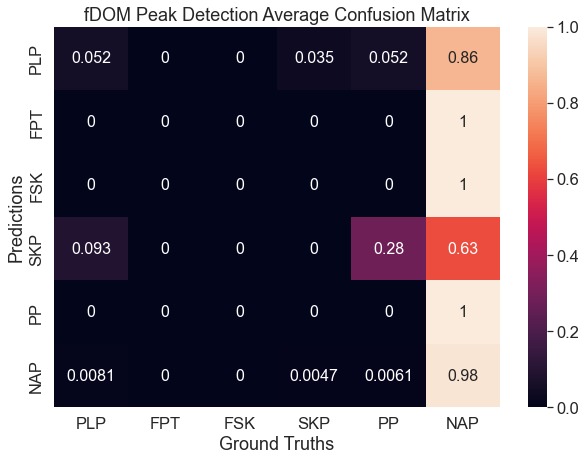

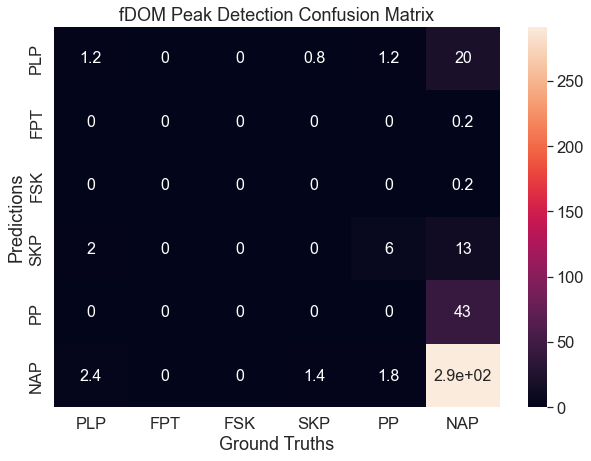

In [24]:
mean_f1 = 0
mean_ba = 0
mean_precision = 0
mean_acc = 0

for key in accumulated_test_metrics:
    metrics = accumulated_test_metrics[key]

    mean_f1 += metrics["f1"]
    mean_ba += metrics["ba"]
    mean_precision += metrics["precision"]
    mean_acc += metrics["acc"]

print("Mean Test F1: ", mean_f1 / len(accumulated_test_metrics))
print("Mean Test BA: ", mean_ba / len(accumulated_test_metrics))
print("Mean Test Acc: ", mean_acc / len(accumulated_test_metrics))
print("Mean Test Precision: ", mean_precision / len(accumulated_test_metrics))

print("Training time: ", overall_end_time - overall_start)

mean_cfmx = np.zeros((6, 6))
for key in accumulated_cfmxs.keys():
    mean_cfmx += accumulated_cfmxs[key]

mean_cfmx = mean_cfmx / len(accumulated_cfmxs)

plt.figure(figsize=(10, 7))
plt.title(label="fDOM Peak Detection Average Confusion Matrix")

sn.set(font_scale=1.5)

sn.heatmap(
    pd.DataFrame(
        mean_cfmx.astype("float") / mean_cfmx.sum(axis=1)[:, np.newaxis],
        index=DATA_LABELS,
        columns=DATA_LABELS,
    ),
    annot=True,
    annot_kws={"size": 16},
)

plt.xlabel("Ground Truths")
plt.ylabel("Predictions")
plt.show()

plt.figure(figsize=(10, 7))
plt.title(label="fDOM Peak Detection Confusion Matrix")

sn.set(font_scale=1.5)

sn.heatmap(
    pd.DataFrame(
        mean_cfmx,
        index=DATA_LABELS,
        columns=DATA_LABELS,
    ),
    annot=True,
    annot_kws={"size": 16},
)

plt.xlabel("Ground Truths")
plt.ylabel("Predictions")
plt.show()


In [17]:
# Pickle statistics

### Statistics from individual classifiers

In [23]:
# print accuracies
print("PLP CLASSIFIER INFO:")
print("ACC: " + str(plp_classifer.best_acc))
print("f1: " + str(plp_classifer.best_f1_score))
print("\n")

print("SKP CLASSIFIER INFO:")
print("ACC: " + str(skp_classifier.best_acc))
print("f1: " + str(skp_classifier.best_f1_score))
print("\n")

print("PP CLASSIFIER INFO:")
print("ACC: " + str(pp_classifier.best_acc))
print("f1: " + str(pp_classifier.best_f1_score))
print("\n")


PLP CLASSIFIER INFO:
ACC: 0.6846560846560846
f1: 0.4827586206896552


SKP CLASSIFIER INFO:
ACC: 0.6925865800865801
f1: 0.41545893719806765


PP CLASSIFIER INFO:
ACC: 0.6568783068783068
f1: 0.357429718875502


